In [ ]:
import Function as F
import DefineFiles as D
import importlib
import tracking as tr
importlib.reload(F)
importlib.reload(D) 
importlib.reload(tr)
from Function import *
from DefineFiles import *
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import ruptures as rpt
import tracking as tr

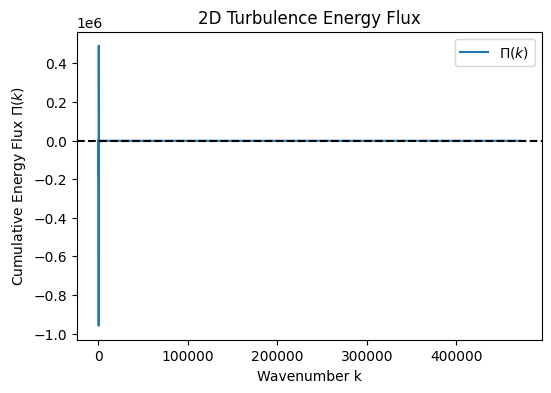

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) 데이터 불러오기
# -----------------------------
u, v = sep('../valid/u/0.5_ux_uy_data.txt')
u, v = resizing(u, v)

N = u.shape[0]  # 격자 크기(N x N)
L = 6.283
dx = L / N

# -----------------------------
# 2) FFT, 파수축 설정
# -----------------------------
fft2  = np.fft.fft2
ifft2 = np.fft.ifft2
fftfreq = np.fft.fftfreq

kx = fftfreq(N, d=dx) * N  # 0,1,2,...,N/2, -N/2+1,...,-1
ky = fftfreq(N, d=dx) * N
kx2d, ky2d = np.meshgrid(kx, ky)

# u, v의 푸리에 변환
u_hat = fft2(u)
v_hat = fft2(v)

# -----------------------------
# 3) Alias 필터링 (2/3 Rule)
# -----------------------------
k_cut = N // 3
mask = (np.abs(kx2d) > k_cut) | (np.abs(ky2d) > k_cut)

# in-place로 필터링
u_hat[mask] = 0.0
v_hat[mask] = 0.0

# -----------------------------
# 4) 비선형 항 계산 ( (u·∇)u )
# -----------------------------
# 스펙트럴 미분 연산자
ikx = 1j * 2*np.pi * kx2d
iky = 1j * 2*np.pi * ky2d

# (a) u_hat, v_hat으로부터 각 성분의 미분(푸리에 공간)
#     dudx_hat = ikx * u_hat, etc.
dudx_hat = ikx * u_hat
dudy_hat = iky * u_hat
dvdx_hat = ikx * v_hat
dvdy_hat = iky * v_hat

# (b) 역푸리에 변환 -> 실공간 미분값
dudx = ifft2(dudx_hat).real
dudy = ifft2(dudy_hat).real
dvdx = ifft2(dvdx_hat).real
dvdy = ifft2(dvdy_hat).real

# (c) 필터링된 속도장(실공간)
u_filtered = ifft2(u_hat).real
v_filtered = ifft2(v_hat).real

# (d) 비선형 항 (u·∇)u = [u dudx + v dudy,  u dvdx + v dvdy]
adv_x = u_filtered * dudx + v_filtered * dudy
adv_y = u_filtered * dvdx + v_filtered * dvdy

# -----------------------------
# 5) 비선형 항 푸리에 변환
# -----------------------------
adv_x_hat = fft2(adv_x)
adv_y_hat = fft2(adv_y)

# -----------------------------
# 6) 에너지 전달률 T(k_x, k_y)
#     T(k_x, k_y) = - Re[ u^*_k · (u·∇u)_k ]
# -----------------------------
transfer_k = -(u_hat.conjugate() * adv_x_hat + v_hat.conjugate() * adv_y_hat)
transfer_k = transfer_k.real  # 실수부만 취함

# -----------------------------
# 7) 파수 크기별 쉘 통합
# -----------------------------
k_mag = np.sqrt(kx2d**2 + ky2d**2)
k_int = np.round(k_mag).astype(int)
k_max = k_int.max()

T_shell = np.zeros(k_max+1)
for ki in range(k_max+1):
    T_shell[ki] = transfer_k[k_int == ki].sum()

# -----------------------------
# 8) 에너지 플럭스 Pi(k)
#     Pi(k) = - \sum_{q=0}^k T_shell(q)
# -----------------------------
Pi = -np.cumsum(T_shell)

# -----------------------------
# 9) 결과 시각화
# -----------------------------
k_vals = np.arange(k_max+1)


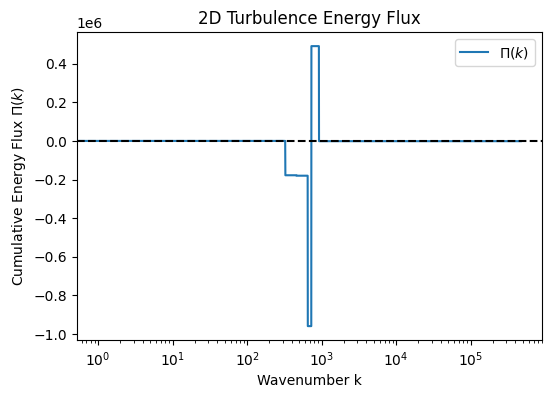

In [15]:
plt.figure(figsize=(6,4))
plt.plot(k_vals, Pi, label=r'$\Pi(k)$')
plt.xscale('log')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Wavenumber k')
plt.ylabel(r'Cumulative Energy Flux $\Pi(k)$')
plt.title('2D Turbulence Energy Flux')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyfftw
import numexpr as ne

# FFT 최적화 설정
np.fft.fft2 = pyfftw.interfaces.numpy_fft.fft2
np.fft.ifft2 = pyfftw.interfaces.numpy_fft.ifft2
pyfftw.interfaces.cache.enable()

u, v = sep('../valid/u/0.5_ux_uy_data.txt')
u, v = resizing(u, v)
N = u.shape[0]

# 파수 공간 좌표 설정
L = 1.0
dx = L / N
kx = np.fft.fftfreq(N, d=dx) * N
ky = np.fft.fftfreq(N, d=dx) * N
kx2d, ky2d = np.meshgrid(kx, ky)

# 속도장의 푸리에 변환
u_hat = np.fft.fft2(u)
v_hat = np.fft.fft2(v)

# Alias 필터링 최적화
k_cut = N // 3
mask = np.where((np.abs(kx2d) > k_cut) | (np.abs(ky2d) > k_cut), True, False)
u_hat[mask] = 0.0
v_hat[mask] = 0.0

# 비선형 항 계산
ikx, iky = 1j * 2 * np.pi * kx2d, 1j * 2 * np.pi * ky2d
dudx = np.fft.ifft2(ikx * u_hat).real
dudy = np.fft.ifft2(iky * u_hat).real
dvdx = np.fft.ifft2(ikx * v_hat).real
dvdy = np.fft.ifft2(iky * v_hat).real

# 비선형 항
u_real, v_real = np.fft.ifft2(u_hat).real, np.fft.ifft2(v_hat).real
adv_x = u_real * dudx + v_real * dudy
adv_y = u_real * dvdx + v_real * dvdy

# 비선형 항의 푸리에 변환
adv_x_hat = np.fft.fft2(adv_x)
adv_y_hat = np.fft.fft2(adv_y)

# 에너지 전달률 T(k_x, k_y)
transfer_k = - (u_hat.conj() * adv_x_hat + v_hat.conj() * adv_y_hat).real

# 파수 크기별 적분 최적화
k_mag = np.sqrt(kx2d**2 + ky2d**2)
k_int = np.round(k_mag).astype(int)
k_max = k_int.max()
T_shell = np.bincount(k_int.ravel(), weights=transfer_k.ravel(), minlength=k_max+1)

# 에너지 플럭스 Pi(k) 계산
Pi = ne.evaluate("-cumsum(T_shell)")

# 시각화
plt.figure(figsize=(6, 4))
plt.plot(np.arange(k_max+1), Pi, label=r'$\Pi(k)$')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Wavenumber k')
plt.ylabel('Cumulative Energy Flux $\Pi(k)$')
plt.title('2D Turbulence Energy Flux')
plt.legend()
plt.show()


In [ ]:
u, v = sep('../valid/u/0.5_ux_uy_data.txt',)
u, v = resizing(u, v)


N = u.shape[0]  # 격자 크기 (N x N)

# 1. 파수 공간 좌표 설정
L = 6.283             # 물리 공간 도메인 크기 (여기서는 1로 가정; 필요시 수정)
dx = L / N           # 격자 간격
# fftfreq를 사용하여 각 축의 파수 벡터 생성 (단위: 주파수, 도메인=1에서 실질적으로 모드 인덱스)
kx = np.fft.fftfreq(N, d=dx) * N  # 0,1,2,...,N/2,-N/2+1,...,-1 형태의 파수 인덱스
ky = np.fft.fftfreq(N, d=dx) * N
kx2d, ky2d = np.meshgrid(kx, ky)  # 2D 파수 그리드

# 2. 속도장의 푸리에 변환
u_hat = np.fft.fft2(u)
v_hat = np.fft.fft2(v)

# 3. 비선형 항 계산을 위한 Alias 필터링 (2/3 법칙 적용)
# 높은 파수 성분을 제거하여 aliasing 방지&#8203;:contentReference[oaicite:5]{index=5} 
k_cut = N // 3  # 컷오프 파수 (N/3)
mask = (np.abs(kx2d) > k_cut) | (np.abs(ky2d) > k_cut)
u_hat_filtered = u_hat.copy()
v_hat_filtered = v_hat.copy()
u_hat_filtered[mask] = 0.0
v_hat_filtered[mask] = 0.0

# 4. 비선형 항 (convective term) 계산: (u · ∇)u 
#   - 주의: 운동량 방정식에서는 비선형 항이 -(u·∇)u 로 나타나므로 부호는 나중에 처리
# 먼저 필터링된 속도장의 공간 미분을 스펙트럴 방식으로 계산합니다.
ikx = 1j * 2*np.pi * kx2d  # d/dx 연산자에 대응하는 파수 공간 계수 (i*kx)
iky = 1j * 2*np.pi * ky2d  # d/dy 연산자 (i*ky)
# 필터링된 속도장의 미분 (역푸리에 변환하여 실공간으로 가져옵니다)
dudx = np.fft.ifft2(ikx * u_hat_filtered).real
dudy = np.fft.ifft2(iky * u_hat_filtered).real
dvdx = np.fft.ifft2(ikx * v_hat_filtered).real
dvdy = np.fft.ifft2(iky * v_hat_filtered).real

# 실공간에서 비선형 항 계산
u_filtered = np.fft.ifft2(u_hat_filtered).real  # 필터링된 실공간 u
v_filtered = np.fft.ifft2(v_hat_filtered).real  # 필터링된 실공간 v
adv_x = u_filtered * dudx + v_filtered * dudy   # (u·∇)u의 x-성분
adv_y = u_filtered * dvdx + v_filtered * dvdy   # (u·∇)u의 y-성분

# 5. 비선형 항의 푸리에 변환 (NL_k 계산)
adv_x_hat = np.fft.fft2(adv_x)
adv_y_hat = np.fft.fft2(adv_y)

# 6. 에너지 전달률 T(k_x, k_y) 계산
# 각 모드에서의 에너지 전달: Re[ u^*_k · NL_k ]
# (여기서 NL_k는 -(u·∇u)_k 이므로 이미 adv_term을 계산했을 때 부호 고려)
# 실제 에너지 전달 T = -Re[u^* · (u·∇u)_hat]으로 부호 변경
transfer_k = - (u_hat.conj()*adv_x_hat + v_hat.conj()*adv_y_hat)  # 복소수 값
transfer_k = transfer_k.real  # 모드별 에너지 전달 (실수부)

# 7. 파수 크기별로 T(k) 적분 (동일한 k=|k|인 쉘의 합)
k_mag = np.sqrt(kx2d**2 + ky2d**2)       # 각 모드의 파수 크기
k_int = np.round(k_mag).astype(int)      # 가장 가까운 정수 파수 인덱스
k_max = k_int.max()
T_shell = np.zeros(k_max+1)
for ki in range(k_max+1):
    T_shell[ki] = transfer_k[k_int == ki].sum()

# 8. 에너지 플럭스 Pi(k) 계산: 0부터 k까지의 누적 에너지 전달(-부호 누적)&#8203;:contentReference[oaicite:6]{index=6}
Pi = -np.cumsum(T_shell)

# 9. 결과 출력 및 시각화
# 에너지 플럭스 Pi(k) vs. k 플롯
k_vals = np.arange(k_max+1)
plt.figure(figsize=(6,4))
plt.plot(k_vals, Pi, label=r'$\Pi(k)$')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Wavenumber k')
plt.ylabel('Cumulative Energy Flux $\Pi(k)$')
plt.title('2D Turbulence Energy Flux')
plt.legend()
plt.show()
